In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# identify the data files
level = 0 # level out of 0,1,2,3,4 in curriculum learning
path = "older_versions/gw_data_notO3_seq_first1000/{}/time_series_{}/".format(str(level), str(level))
all_files = os.listdir(path)
files = []
#print(all_files)
for file in all_files:
    cond1 = file.endswith("npy")
    cond2 = not("test" in file) and not("train" in file)
    cond3 = len(file)==17
    cond4 = True #not("240") in file
    if (cond1 and cond2 and cond3 and cond4):
        files.append(file)
print(files[:13])
print(files[-13:])

# these numbers in range (0,1) define which part of the Fourier spectrum array to keep
include_from_ratio = 0.01 #0.01
include_to_ratio = 0.20 #0.20

# deduce dimensionality of the whole dataset
ncols_raw = len(np.load(path+files[0]))
print("\nncols_raw =", ncols_raw)
ncols = len(range(int(ncols_raw*include_from_ratio),int(ncols_raw*include_to_ratio))) # cut redundant part of the FT
print("ncols =", ncols)
nrows = len(files) // 3 # 3 channels, one for each measuring location (H/L/V)
print("nrows =", nrows)

# X for time/freq. data, y for labels (0:no event/1:GW event)
X = np.zeros((nrows, 3, ncols)) # 3 channels, one for each measuring location (H/L/V)
y = np.zeros((nrows))
print("Shape of X:", np.shape(X))

# mapping from location labels H/L/V to channel indices
loc_map = {"H":0, "L":1, "V":2}

['00000000_0_H1.npy', '00000000_0_L1.npy', '00000000_0_V1.npy', '00000000_1_H1.npy', '00000000_1_L1.npy', '00000000_1_V1.npy', '00000001_0_H1.npy', '00000001_0_L1.npy', '00000001_0_V1.npy', '00000001_1_H1.npy', '00000001_1_L1.npy', '00000001_1_V1.npy', '00000002_0_H1.npy']
['00000997_1_V1.npy', '00000998_0_H1.npy', '00000998_0_L1.npy', '00000998_0_V1.npy', '00000998_1_H1.npy', '00000998_1_L1.npy', '00000998_1_V1.npy', '00000999_0_H1.npy', '00000999_0_L1.npy', '00000999_0_V1.npy', '00000999_1_H1.npy', '00000999_1_L1.npy', '00000999_1_V1.npy']

ncols_raw = 155648
ncols = 29573
nrows = 2000
Shape of X: (2000, 3, 29573)


file name template: 0000001_1_H1.npy

file_idx, file, row_idx, csv
0 00000000_0_H1.npy 0 0_0
1 00000000_0_L1.npy 0 0_0
2 00000000_0_V1.npy 0 0_0
3 00000000_1_H1.npy 1000 0_1
4 00000000_1_L1.npy 1000 0_1
5 00000000_1_V1.npy 1000 0_1
00000001_0_H1.npy


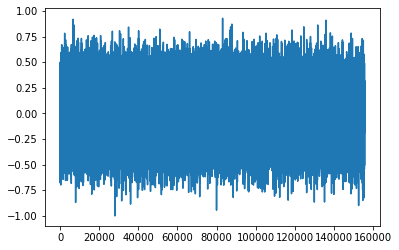

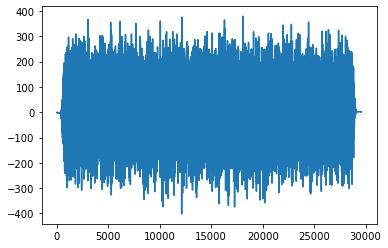

6 00000001_0_H1.npy 1 1_0
7 00000001_0_L1.npy 1 1_0
8 00000001_0_V1.npy 1 1_0
9 00000001_1_H1.npy 1001 1_1
10 00000001_1_L1.npy 1001 1_1
11 00000001_1_V1.npy 1001 1_1
12 00000002_0_H1.npy 2 2_0
13 00000002_0_L1.npy 2 2_0
14 00000002_0_V1.npy 2 2_0
15 00000002_1_H1.npy 1002 2_1
16 00000002_1_L1.npy 1002 2_1
17 00000002_1_V1.npy 1002 2_1
18 00000003_0_H1.npy 3 3_0
19 00000003_0_L1.npy 3 3_0
...


KeyboardInterrupt: 

In [38]:
print("file_idx, file, row_idx, csv") # for logging how files are mapped to rows in X

for file_idx, file in enumerate(files):
    
    # load time series and FT it
    time_signal = np.load(path + file)
    freq_signal = np.fft.fft(time_signal)
    freq_signal = np.real(freq_signal)
    freq_signal = freq_signal[ int(ncols_raw*include_from_ratio) : int(ncols_raw*include_to_ratio) ]

    # identify the label of location (H/L/V)
    loc_code = file[11]
    channel_idx = loc_map[loc_code]
    
    # identify the code number of the event
    event_idx = int(file[0:8]) - int(level*1e4) # first 8 digits in the filename label the event
    is_event = int(file[9]) # position of encoding 0/1 in the filename 
    row_idx = event_idx + nrows//2 * is_event
    
    # assign the data
    X[row_idx, channel_idx, :] = freq_signal # non-events take the first 1/2 of 0th dimension, events the latter half
    y[row_idx] = is_event
    
    # see whether we can reconstruct the csv file name just based on row_idx
    # this will be needed later, when analysing cnn results
    isEvent_from_rowIdx = int(row_idx >= nrows//2)
    eventIdx_from_rowIdx = row_idx - nrows//2 * isEvent_from_rowIdx
    csv = "{}_{}".format(eventIdx_from_rowIdx, isEvent_from_rowIdx)
    
    if file_idx < 20:
        print(file_idx, file, row_idx, csv)
    elif file_idx == 20:
        print("...")
    elif abs(file_idx - len(files))<=6:
        print(file_idx, file, row_idx, csv)

np.save("X_FT_GData1000_{}".format(level), X)
np.save("X_FT_GLabels1000_{}".format(level), y)

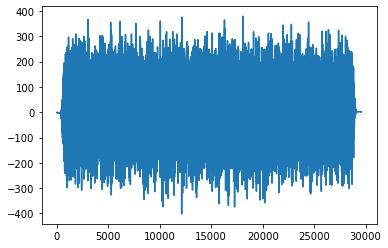

In [39]:
plt.plot(X[1,0,:])
plt.show()
FT_00000001_0_H1.npy
np.save("FT_00000001_0_H1.npy", X[1,0,:])

In [28]:
np.save("X_FT_GData1000_{}".format(level), X)
np.save("X_FT_GLabels1000_{}".format(level), y)

In [13]:
"""
plt.plot(X[0,0,:])
plt.show()

print(np.shape(X))
    
# Fourier transform to get it from time domain to frequency domain
X = X[:, :, :int(ncols_raw)]
print(np.shape(X), "upon FT")
ncols_reduced = np.shape(X)[-1]
X = np.fft.fft(X) # FT, by default along the last (time) dimension
print(np.shape(X))
X = np.real(X) # only real part
print(np.shape(X))
# reshape in the last dimension by extracting only the relevant part of the spectrum
X = X[:, :, int(ncols_reduced*include_from_ratio):int(ncols_reduced*include_to_ratio)] # cutoff frequency
print(np.shape(X))
X = X.astype("float32")

plt.plot(X[0,0,:])
plt.title(files[0])
plt.show()

nrows, nchans, ncols = np.shape(X)
print((nrows, nchans, ncols))
"""

None


test:
 [  8  11  18  19  20  24  30  36  41  42  47  48  60  69  70  71  72  80
  82  84  90  91  92  95  99 100 103 111 114 118 123 125 127 134 135 142
 146 148 149 150 153 154 159 165 171 172 176 180 181 194] 

train:
 [  0   1   2   3   4   5   6   7   9  10  12  13  14  15  16  17  21  22
  23  25  26  27  28  29  31  32  33  34  35  37  38  39  40  43  44  45
  46  49  50  51  52  53  54  55  56  57  58  59  61  62  63  64  65  66
  67  68  73  74  75  76  77  78  79  81  83  85  86  87  88  89  93  94
  96  97  98 101 102 104 105 106 107 108 109 110 112 113 115 116 117 119
 120 121 122 124 126 128 129 130 131 132 133 136 137 138 139 140 141 143
 144 145 147 151 152 155 156 157 158 160 161 162 163 164 166 167 168 169
 170 173 174 175 177 178 179 182 183 184 185 186 187 188 189 190 191 192
 193 195 196 197 198 199]

event_indices:
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  

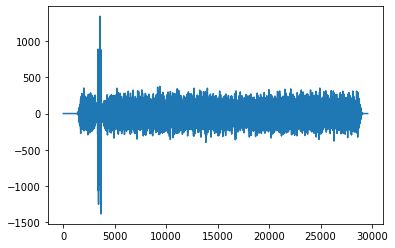

In [5]:
"""
# train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
indices = np.arange(nrows)
indices_train = np.random.choice(indices, int(nrows*0.75), replace=False) # int(nrows*0.75)
indices_test = [idx for idx in indices if not(idx in indices_train)  ] 
print("test:\n", np.sort(indices_test), "\n")
print("train:\n",np.sort(indices_train))

X_train = np.zeros((len(indices_train), 3, ncols))
y_train = np.zeros((len(indices_train)))
X_test = np.zeros((len(indices_test), 3, ncols))
y_test = np.zeros((len(indices_test)))

event_indices = np.arange(nrows)
#np.random.shuffle(event_indices)
print("\nevent_indices:\n", event_indices)

for channel_idx in range(3):
    event_idx_train, event_idx_test = 0, 0
    for event_idx in event_indices:
        if event_idx in indices_train:
            X_train[event_idx_train, channel_idx, :] = X[event_idx, channel_idx, :]
            y_train[event_idx_train] = y[event_idx]
            event_idx_train += 1
        elif event_idx in indices_test:
            X_test[event_idx_test, channel_idx, :] = X[event_idx, channel_idx, :]
            y_test[event_idx_test] = y[event_idx]
            event_idx_test += 1
        else:
            print("Error, unvalid index: ", event_idx)
            break

print("\nshapes of X_train, y_train, X_test, y_test:\n",np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test))
print("\n\nExample spectrum:")
plt.plot(X_train[0,0,:])
plt.show()
"""

In [12]:
# save arrays
suffix = ""
np.save(path+"X_train"+suffix, X_train)
np.save(path+"X_test"+suffix, X_test)
np.save(path+"y_train"+suffix, y_train)
np.save(path+"y_test"+suffix, y_test)

# Supplementary code

In [ ]:
# look at csv files
files_csv = [file for file in all_files if "csv" in file]
#print(files_csv)
pd.read_csv(path+files_csv[0])

In [6]:
# check that indices_train and indices_test do not overlap and are complete
s = 0
for i in indices_train:
    if i in indices_test:
        s += 1
for i in indices_test:
    if i in indices_train:
        s += 1
s

0

In [10]:
# do not use this
"""
def custom_split(X, y, test_size=0.2):
    
    nrows, nchans, ncols = np.shape(X)
    
    indices = np.arange(nrows)
    indices_train = np.random.choice(indices, int(nrows*(1 - test_size)), replace=False) # int(nrows*0.75)
    indices_test = [idx for idx in indices if not(idx in indices_train)  ] 
    #print(indices_test)
    #print(indices_train)

    X_train = np.zeros((len(indices_train), 3, ncols))
    y_train = np.zeros((len(indices_train)))
    X_test = np.zeros((len(indices_test), 3, ncols))
    y_test = np.zeros((len(indices_test)))
    
    event_indices = np.arange(nrows)
    #np.random.shuffle(event_indices)

    for channel_idx in range(nchans):
        # initialize indices
        event_idx_train, event_idx_test = 0, 0
        for event_idx in :
            if event_idx in indices_train:
                X_train[event_idx_train, channel_idx, :] = X[event_idx, channel_idx, :]
                y_train[event_idx_train] = y[event_idx]
                event_idx_train += 1
            elif event_idx in indices_test:
                X_test[event_idx_test, channel_idx, :] = X[event_idx, channel_idx, :]
                y_test[event_idx_test] = y[event_idx]
                event_idx_test += 1
            else: 
                print("Error, unvalid index: ", event_idx)
                break

    #print(np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test))
    return indices_test, X_train, X_test, y_train, y_test
"""

In [6]:
y_train

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [44]:
np.shape(np.concatenate((X,y.T), axis=))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)

In [61]:
n = 200
arr = np.arange(n)
np.random.shuffle(arr)
arr

array([ 58, 162, 195,  87,  90,  28, 172, 132, 194, 109, 178,  70,  10,
        60, 131, 110, 196, 183,  61,  98, 169, 114,  50,  12,  67,  24,
       112, 137,  51,  62, 149, 124,  18,  39,  56, 121, 152, 144,  11,
       156,  23, 163, 106,  99, 117,  69,  41,  66, 101, 126, 111, 164,
        16,  91, 148,   0,  46,  97,  34, 186,  29, 140,  53,  20, 153,
       166,  25, 141, 138,  42, 182, 123,  82,  27,  74, 127, 174,  94,
        31, 198,  65,  84,  43, 122,  21, 176,  57,  79, 179,  73,  13,
       155, 193,  49, 171, 118,  88, 136, 107, 102, 177,  44, 143,  93,
         3, 185,  85,  55, 146, 199, 168,   1,  78, 104,  71, 197,  72,
       150,  83, 128, 105,  45,  47,   4,  22, 129,  96, 173,   6,  36,
       130, 192, 147,  81,  40, 180,  80, 190, 160,  77, 100, 181, 119,
        37,  63,  30, 135, 159, 134, 145,  59, 133, 125,  86, 157,  76,
        68,  52,  92,  33,  14, 170,  95,  35,  54, 151, 189, 184, 161,
       165, 115, 103, 187,  26, 154,  38,  64, 142, 188, 191,   

In [23]:
# a demo on how to reshape two arrays of different dimensionality with a consistent first axis

Xtr = np.array([
               [[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9],
                [10,11,12]],
               [[10, 20, 30],
                [40, 50, 60],
                [70, 80, 90],
                [100,110,120]]
               ]).reshape((4,3,2))
                
ytr = np.array(["a","b","c","d"])

print(np.shape(Xtr), np.shape(ytr))
print("\n", Xtr, "\n\n", ytr, "\n")
print("==================================\nRESHUFFLE:\n==================================\n")
from sklearn.utils import shuffle
Xtr, ytr = shuffle(Xtr, ytr, random_state=0)
print(Xtr, "\n\n", ytr)

(4, 3, 2) (4,)

 [[[  1   2]
  [  3   4]
  [  5   6]]

 [[  7   8]
  [  9  10]
  [ 11  12]]

 [[ 10  20]
  [ 30  40]
  [ 50  60]]

 [[ 70  80]
  [ 90 100]
  [110 120]]] 

 ['a' 'b' 'c' 'd'] 

RESHUFFLE:

[[[ 10  20]
  [ 30  40]
  [ 50  60]]

 [[ 70  80]
  [ 90 100]
  [110 120]]

 [[  7   8]
  [  9  10]
  [ 11  12]]

 [[  1   2]
  [  3   4]
  [  5   6]]] 

 ['c' 'd' 'b' 'a']


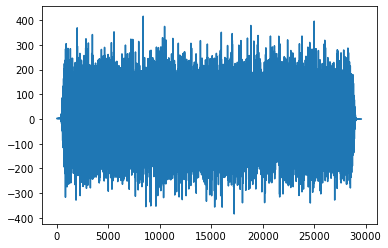

In [4]:
import time
import numpy as np

In [21]:
t1 = time.time()
X = np.load("older_versions/gw_data_mini/00000000_0_H1.npy")
t2 = time.time()
print(t2 - t1)

0.0009214878082275391


In [18]:
t3 = time.time()
Xf = np.fft.fft(X)
t4 = time.time()
print(t4 - t3)

0.01046299934387207


In [12]:
print(t2-t1)

0.0009250640869140625
